In [117]:
import os
import time
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [141]:
# set path to folder containing clinic watch data
clinicpath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to folder containing home watch data
homepath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Patient Record Correlation'
# set path to destination folder
features = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [142]:
# generate task abbreviation dictionary
ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [6]:
DataFeatures = pd.read_csv(os.path.join(features, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
DataFeatures.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,RMSX,RMSY,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,1003.0,0,Drnkg,0,1.0,1.0,0.0,1.0,0.003307,0.002409,...,1.280704,1.386294,1.396967,0.000703,0.065298,0.006188,0.009186,3.487845,14.708341,0.012476
1,1003.0,0,Drnkg,1,1.0,1.0,0.0,1.0,0.005253,0.008123,...,0.959580,0.575852,0.742688,0.005957,0.897089,0.034245,0.087334,6.468010,51.769176,0.011136
2,1003.0,0,Drnkg,2,1.0,1.0,0.0,1.0,0.005203,0.009098,...,1.217019,0.722551,0.846374,0.006222,0.897081,0.042083,0.088483,6.029726,46.903740,0.011594
3,1003.0,0,Drnkg,3,1.0,1.0,0.0,1.0,0.004530,0.006995,...,1.207064,0.759448,0.988522,0.002867,0.262082,0.024327,0.038040,2.970488,10.522799,0.014210
4,1003.0,0,Drnkg,4,1.0,1.0,0.0,1.0,0.006927,0.013675,...,1.319454,0.953987,1.503321,0.007170,0.752276,0.065797,0.091757,3.083533,14.513282,0.016023


In [30]:
features_list = list(DataFeatures.columns[8:])
MetaData = DataFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall']]
Features = StandardScaler().fit_transform(DataFeatures[features_list].values)

pca = PCA(n_components = 3)
princComp = pca.fit_transform(Features)
princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2', 'PC3'])
DataPCA = pd.concat([MetaData, princComp], axis = 1)
DataPCA.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,PC1,PC2,PC3
0,1003.0,0,Drnkg,0,1.0,1.0,0.0,1.0,-1.876328,0.759233,-0.687481
1,1003.0,0,Drnkg,1,1.0,1.0,0.0,1.0,0.213879,3.029143,-2.035008
2,1003.0,0,Drnkg,2,1.0,1.0,0.0,1.0,0.205672,2.509805,-1.690183
3,1003.0,0,Drnkg,3,1.0,1.0,0.0,1.0,-0.607318,0.473538,-1.565453
4,1003.0,0,Drnkg,4,1.0,1.0,0.0,1.0,0.243753,-0.335153,-0.410634


In [100]:
def plotPCA(sympt, tasks, scored, comp):
    
    features_list = list(DataFeatures.columns[8:])
    MetaData = DataFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall']]
    Features = StandardScaler().fit_transform(DataFeatures[features_list].values)

    pca = PCA(n_components = comp)
    princComp = pca.fit_transform(Features)
    if comp == 3:
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2', 'PC3'])
    if comp == 2:
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2'])
    
    DataPCA = pd.concat([MetaData, princComp], axis = 1)
    indices = (x for x in range(len(DataPCA)) if DataPCA.TaskAbb.values[x] in tasks)
    DataPCA = DataPCA.loc[indices]
    
    if comp == 3:
        fig = plt.figure(figsize = (16, 12))
        ax = Axes3D(fig)
    if comp == 2:
        plt.figure(figsize = (16, 12))
    if scored:
        Scores = list(DataPCA[sympt].unique())
    else:
        Scores = ['Symptomatic', 'Non-Symptomatic']
    for score in Scores:
        if not type(score) == str:
            if np.isnan(score):
                continue
        if scored or sympt == 'TaskAbb':
            ScoreData = DataPCA[DataPCA[sympt] == score]
        elif score == 'Symptomatic':
            ScoreData = DataPCA[DataPCA[sympt] > 0]
        elif score == 'Non-Symptomatic':
            ScoreData = DataPCA[DataPCA[sympt] == 0]
        if comp == 3:
            ax.scatter(ScoreData.PC1.values, ScoreData.PC2.values, ScoreData.PC3.values)
        if comp == 2:
            plt.scatter(ScoreData.PC1.values, ScoreData.PC2.values)
    plt.legend(Scores)
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    if comp == 3:
        ax.set_zlabel('Principle Component 3')
        
#     ax.set_zlim3d(-5, 10)
#     ax.set_ylim3d(-10, 5)
#     ax.set_xlim3d(-5, 10)
    
    return DataPCA

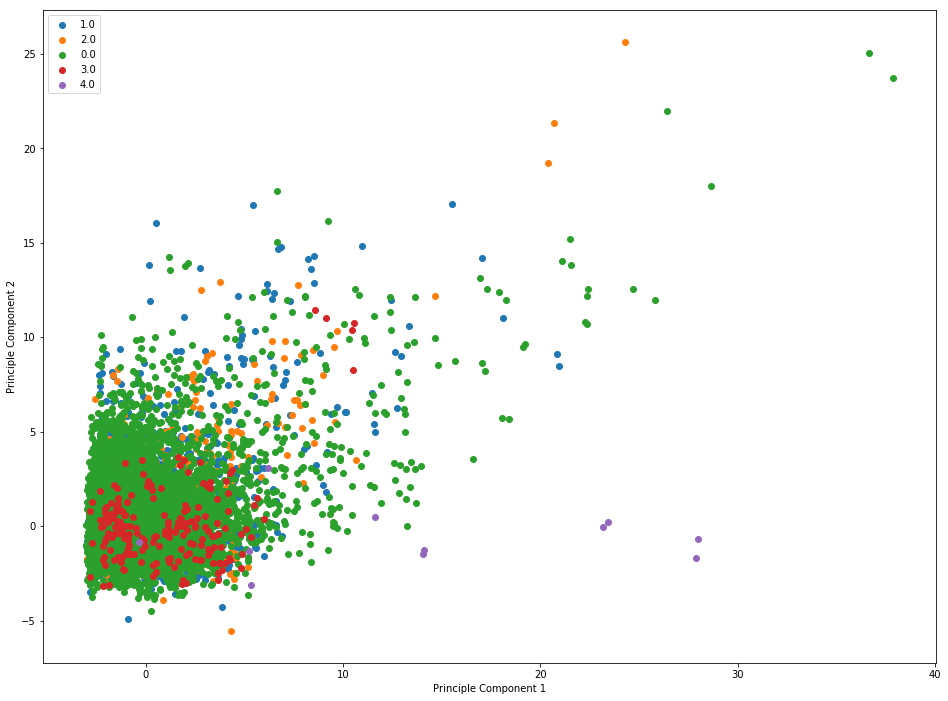

In [116]:
### TASKS
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']
# tasks = ['RamL', 'RamR']
# tasks = ['FtnL', 'FtnR']
# tasks = ['Sitng', 'Stndg', 'Drwg']
# tasks = ['Wlkg', 'WlkgCnt']
tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']

### LABEL_TYPE
# label_type = 'TaskAbb'
label_type = 'Tremor'
# label_type = 'Bradykinesia'
# label_type = 'Dyskinesia'
# label_type = 'Overall'

DataPCA = plotPCA(label_type, tasks, True, 2)

In [251]:
def TrainTestCluster(tasks, newLab, groups, bestFeatIdx):
    
    pd.options.mode.chained_assignment = None
    
    km = KMeans(n_clusters = len(groups))
    
    DataFeatures = pd.read_csv(os.path.join(features, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    if type(DataFeatures[label_type].values[-1]) != str:
        DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
        DataFeatures = DataFeatures[DataFeatures[label_type].apply(lambda x: groupDict[x]) != 'Excld']
        
    features_list = list(DataFeatures.columns[8:])
    
    if bestFeatIdx:
        best_features_list = []
        for idx in bestFeatIdx:
            best_features_list = best_features_list + [features_list[idx]]
        features_list = best_features_list
        
    print('Tasks Considered:')
    for task in DataFeatures.TaskAbb.unique():
        print('    ' + ClinicTasks[task])
    if newLab:
        print('--------------------------------------------------')
        print('Label Groups:')
        for label in newLab:
            print('    ' + label)
    
    DataClusters = pd.DataFrame()
    
    for subj in DataFeatures.SubjID.unique():
        
        SubjFeatures = DataFeatures[DataFeatures.SubjID == subj]
        X = SubjFeatures[features_list].values
        
        km.fit(X)
        
        ClusterLab = km.labels_
        SubjFeatures['Cluster'] = ClusterLab
        cols = ['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall', 'Cluster'] + features_list
        SubjFeatures = SubjFeatures[cols]
        if DataClusters.empty:
            DataClusters = SubjFeatures
            continue
        DataClusters = pd.concat([DataClusters, SubjFeatures], ignore_index = True)
        
        
        
        MetaData = SubjFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall', 'Cluster']]
        Features = StandardScaler().fit_transform(SubjFeatures[features_list].values)

        pca = PCA(n_components = 2)
        princComp = pca.fit_transform(Features)
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2'])
        print(princComp)
        print(MetaData)

        # CURRENT ISSUE WITH CONCATENATION
        DataPCA = pd.concat([MetaData, princComp], axis = 1)
        print(DataPCA)

        plt.figure(figsize = (8, 6))
        
        Clusters = list(DataPCA.Cluster.unique())
        
        for cluster in Clusters:
            ClusterData = DataPCA[DataPCA.Cluster == cluster]
            plt.scatter(ClusterData.PC1.values, ClusterData.PC2.values)
        plt.legend(Clusters)
        plt.xlabel('Principle Component 1')
        plt.ylabel('Principle Component 2')
        plt.show()
        
    return DataClusters, km

Tasks Considered:
    Finger to nose--left hand
    Finger to nose--right hand
--------------------------------------------------
Label Groups:
    NoSymp
    Symp
          PC1        PC2
0   -3.803494  -0.840985
1   -3.767805  -0.612048
2   -3.093156  -1.896098
3   -3.367036  -1.854833
4   -3.211548  -1.905093
5   -3.891826   0.133440
6   -3.667319  -1.017070
7   -3.243229  -2.355273
8   -3.158416  -2.108638
9   -3.310828  -1.588082
10  -3.477172  -1.480312
11  -3.426830  -1.114703
12  -2.304401   2.859994
13  -2.306023   2.013965
14  -3.349885   6.174211
15  -2.139297   3.238559
16  -2.721963   6.233222
17  -6.921003  11.146916
18  -3.508423  -0.622406
19  -3.226997  -2.789507
20  -3.412012  -1.368092
21  -2.913151  -3.167283
22  -4.177751   1.714296
23  -4.486044   1.956099
24  -3.725400  -0.867087
25  -3.743394   0.245791
26  -4.320495   1.231311
27  -3.615431  -1.752809
28  -3.362421  -3.182785
29  -3.698543  -1.677164
..        ...        ...
113 -3.282329  -1.771361
114 -3.3798

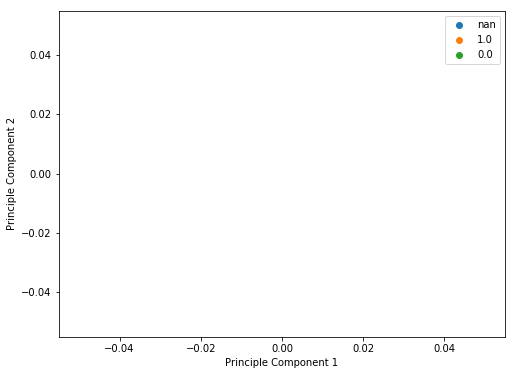

         PC1       PC2
0   4.903499 -3.092064
1   4.749059  0.362222
2   3.782330 -1.106830
3   3.725999 -0.631108
4   5.869753  3.236146
5   6.116061  3.049329
6   4.970568 -0.171360
7   4.192780  0.728779
8   3.267536  0.859012
9   3.615558  0.184481
10  3.265219  3.290839
11 -4.770832 -0.339241
12 -4.272300 -2.449391
13 -4.179188 -2.831042
14 -4.428402 -1.862677
15 -4.701532 -1.065728
16 -4.403774 -1.313240
17 -5.075867  1.287538
18 -4.894371  0.302175
19 -5.228491  3.756110
20 -4.842301  1.586272
21  5.819901 -2.528755
22  4.056647 -1.958551
23  4.278341 -1.223369
24  4.374140 -0.068475
25  5.306348  1.007024
26  5.917382  1.087632
27  4.627502 -0.773860
28  4.172153 -0.214675
29  3.411719  0.406817
..       ...       ...
35 -3.910933 -1.776829
36 -4.352247 -0.867173
37 -4.672808 -0.078536
38 -5.171417  1.156669
39 -4.495104 -1.240866
40 -3.932307 -2.963341
41 -3.396592 -5.575573
42 -3.613725 -2.931703
43  8.067856  0.061826
44  5.935855  1.422686
45  3.439360 -0.907409
46  4.08119

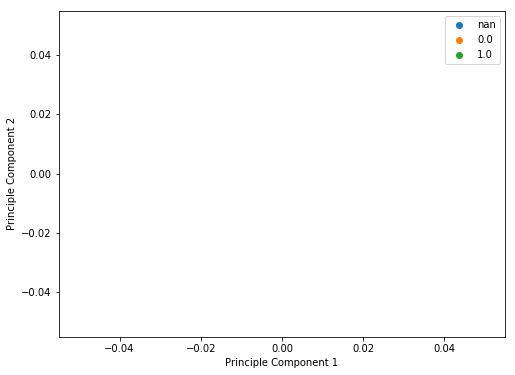

          PC1        PC2
0    3.571676  -1.261794
1    2.619239   0.776801
2    2.046788  -0.356515
3    3.169861  -2.816606
4    4.686119  -3.144417
5    5.369954   3.374013
6    5.108338   3.698970
7    4.168072   1.277455
8    1.957011  -1.734765
9    1.347388  -4.055083
10   1.573874  -2.284771
11  -4.368032  -0.943871
12  -4.670732   2.386508
13  -4.601682   1.815724
14  -4.913651   4.594336
15  -4.174614   1.677113
16  -4.120456  -1.740001
17  -4.110857  -0.304193
18  -4.310267   0.203811
19  -4.202125  -0.770524
20  -4.261532  -1.575187
21  12.469786  10.050259
22   3.997183   0.242749
23   2.586582   1.736804
24   2.490261   0.113450
25   3.424359  -0.227690
26   3.373771  -0.698055
27   4.581662   1.605554
28   4.154014   0.633181
29   2.215245  -1.880269
..        ...        ...
56  -4.508451   2.777153
57  -4.430337   0.549419
58  -4.253474   0.886391
59  -4.203558  -0.088741
60  -4.326545   0.946102
61  -3.868860   0.398515
62  -3.847391  -0.863246
63  -3.896281  -1.484520


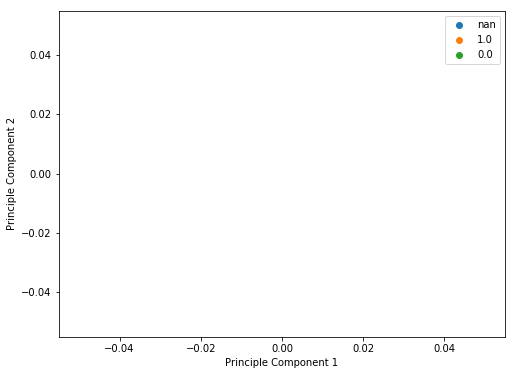

          PC1        PC2
0   -5.215906   3.040496
1   -5.241857  -0.715159
2   -5.162453  -2.102486
3   -5.121379  -1.793895
4   -5.313660  -1.005145
5   -5.242823  -1.883572
6   -5.285021  -0.575348
7   -5.455598   0.328253
8   -5.252339  -1.815793
9   -5.247339  -1.201773
10  -5.310292  -1.060424
11   2.989891  -0.574738
12   3.186752  -0.298000
13   2.408334  -0.653895
14   2.194715   0.476651
15   2.460527   0.181451
16   2.895760  -0.213847
17   2.787892   1.262336
18   2.005479   1.849133
19   1.851084   0.250732
20   2.204059  -0.659505
21   0.974305   0.599715
22  -5.787325   4.330337
23  -5.883637   4.745868
24  -4.672514  -1.663008
25  -5.001779  -0.602542
26  -4.864363  -1.215533
27  -4.913252  -1.525643
28  -4.843787  -1.520381
29  -4.659851  -1.991248
..        ...        ...
102  1.262682  -1.543070
103  1.439679  -1.128950
104  1.094007  -0.939754
105  1.921043  -0.300102
106  1.819836   0.002580
107  1.088129  -1.054048
108  0.957515  -1.078742
109  0.798107  -1.415542


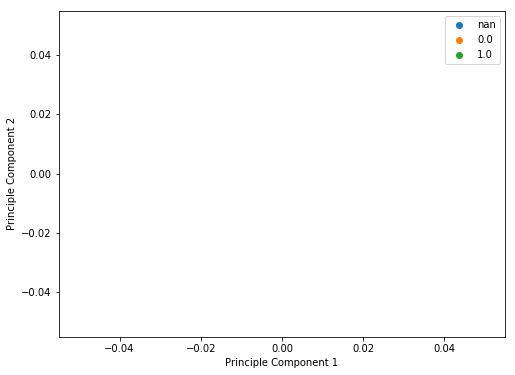

         PC1        PC2
0   6.304860  -0.399340
1   6.161759   0.675220
2   5.932387   0.805853
3   5.286335  -0.330170
4   5.301167   0.169241
5   5.745998  -1.175707
6  -5.304228   0.865377
7  -5.008443  -0.631009
8  -4.761394   0.000467
9  -4.941515  -0.036138
10 -5.059686   1.044366
11 -5.112971  -0.512952
12  5.888334  -1.528254
13  5.553314  -1.066832
14  4.707552  -0.773454
15  6.177950  -1.506663
16  5.427809  -1.698255
17  5.078529  -2.710017
18  5.323902  -2.713217
19 -4.614605  -0.003411
20 -4.568396   0.237118
21 -4.532526  -0.436774
22 -4.462195  -0.268975
23 -4.753179  -0.244167
24 -4.974305  -0.248818
25  3.923783  -3.330201
26  3.358623  -2.825198
27  2.801912  -0.919873
28  2.222556  -1.137345
29  2.650510  -2.191795
..       ...        ...
59 -5.274709  -0.640037
60 -5.237872  -0.675753
61 -5.083576  -0.292071
62  1.328674  -1.617443
63  2.239817   0.999459
64  3.842403  -0.362203
65  3.566885  -1.741075
66  4.138009  -0.312540
67  3.514871   0.272082
68  2.631460   0

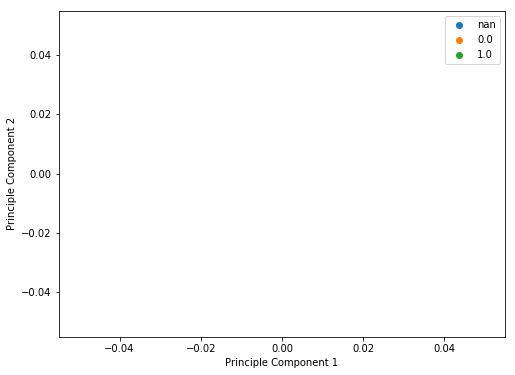

          PC1        PC2
0    2.937131  -1.932542
1    2.750358  -1.632657
2    2.704597  -1.248706
3    2.949673  -0.924169
4    2.766453  -0.887031
5    2.884189  -0.040038
6    3.113868  -0.175198
7   -4.133906  -0.902811
8   -3.848619  -1.813064
9   -3.786046  -2.955122
10  -3.825673  -3.063242
11  -4.040327  -1.962114
12  -3.992423  -2.762307
13  -3.911477  -2.703502
14  -3.995788  -1.890281
15   2.445057  -1.195613
16   1.326245  -1.128097
17   1.458823  -1.257045
18   2.312947  -1.688876
19   1.564178  -0.520975
20   0.860818  -0.180142
21   0.680448   0.371621
22  -3.905930  -1.520554
23  -3.699431  -2.171895
24  -3.094109  -4.112996
25  -3.338490  -3.540227
26  -4.445843   0.519037
27  -4.437269   1.115171
28  -3.690127  -2.238370
29   5.152419  -0.940944
..        ...        ...
55   3.535945  -0.292991
56   3.923204  -1.159737
57   3.374939  -0.246101
58   4.307714  -0.217636
59  -4.597594   1.099855
60  -3.478513  -2.202282
61   9.378431   1.329973
62   6.425664   0.196845


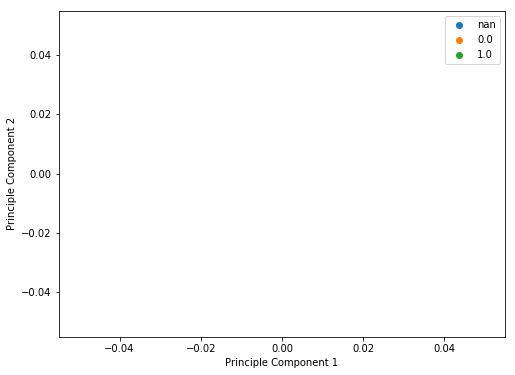

         PC1       PC2
0   3.181991  4.930620
1   2.277417  6.217773
2  -1.013674  0.750401
3  -0.899299  1.215112
4  -1.000601  0.372662
5  -0.573955 -1.304684
6  -4.215204 -0.725102
7  -4.039400  1.088162
8  -4.377065 -0.231134
9  -4.517304 -1.996649
10 -4.595122 -0.077863
11 -4.970484 -2.135483
12  4.965097 -0.946714
13  6.971550  6.957220
14  6.423075  7.402678
15  3.400757  0.291834
16  3.442454  0.706940
17 -4.269985 -0.031564
18 -4.184856 -0.176566
19 -4.466632 -0.462436
20 -4.448989 -0.297031
21 -4.260209 -0.844160
22 -4.174199  1.272152
23  4.636555 -3.289792
24  6.217059  1.433936
25  6.290328  1.323951
26  4.859828 -2.222156
27  4.715106 -1.803939
28  4.397115 -0.701036
29  6.413387 -1.218286
..       ...       ...
58 -4.138795  0.260464
59 -3.939208 -0.171120
60 -4.556639 -0.887180
61  6.659199 -4.802057
62  6.998395 -2.816145
63  6.493943 -2.944915
64  5.212489 -2.512585
65  4.827432 -0.626088
66  3.527522 -1.724084
67  3.512992  1.273634
68 -4.122658  0.647544
69 -3.80148

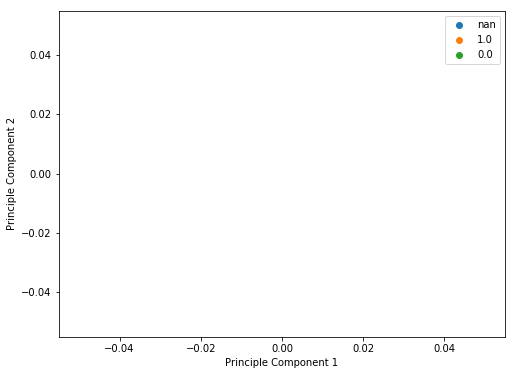

         PC1       PC2
0  -6.203020  4.323408
1  -4.001628 -1.151039
2  -4.444336  0.833395
3  -4.410425  0.660457
4  -5.241900 -0.906486
5  -5.034323 -1.156230
6  -3.824050 -2.523514
7  -5.858788  0.105462
8   6.597324 -1.568253
9   4.635189 -2.832934
10  4.827383  0.912602
11  5.427978  1.240968
12  5.351238 -2.691561
13  4.927273 -0.640491
14  7.252086  5.394216
      SubjID  Visit TaskAbb  Clip  Tremor  Bradykinesia  Dyskinesia  Overall  \
7667  1020.0      6    FtnL     0     1.0           NaN         0.0      0.0   
7668  1020.0      6    FtnL     1     1.0           NaN         0.0      0.0   
7669  1020.0      6    FtnL     2     1.0           NaN         0.0      0.0   
7670  1020.0      6    FtnL     3     1.0           NaN         0.0      0.0   
7671  1020.0      6    FtnL     4     1.0           NaN         0.0      0.0   
7672  1020.0      6    FtnL     5     1.0           NaN         0.0      0.0   
7673  1020.0      6    FtnL     6     1.0           NaN         0.0     

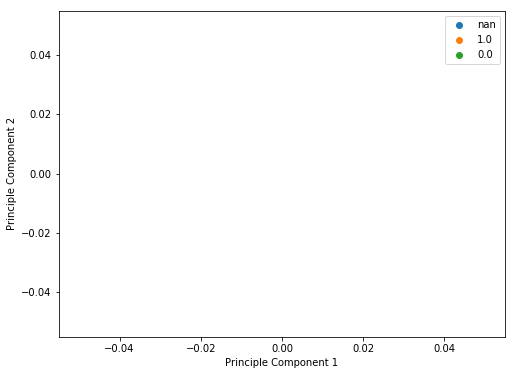

          PC1        PC2
0    7.805492  -0.467263
1    9.399572  -0.963624
2    8.385373  -1.210508
3    9.603189  -0.618013
4   13.921716  -0.541248
5   13.793560  -0.422136
6    0.129447  -0.987261
7   -0.181699  -0.816181
8   -0.272217  -0.699432
9   -0.369093   0.643520
10  -0.262712  -0.834980
11  -0.322730  -0.053034
12  -0.931405   2.211380
13  -4.549315   1.213339
14  -4.355942   1.137834
15  -4.104145   0.257751
16  -3.798306  -0.621276
17  -3.883655   1.312228
18   0.802368  -1.072794
19   1.412681  -1.701013
20   1.215523  -1.193101
21   0.900955  -1.440777
22   0.614155  -1.576974
23  -4.969497   3.921130
24  -5.106232   5.075169
25  -4.929231   4.353038
26  -5.028956   4.026909
27  -4.033439   0.828628
28   1.474855  -1.974806
29   1.731709  -1.479878
..        ...        ...
50  -3.404677  -1.946143
51  -3.101758  -1.630804
52   2.708209   2.535215
53   3.086791  -1.118107
54   2.757837  -1.832931
55   2.005946  -1.959085
56   1.621307  -1.792811
57   1.804952  -1.844767


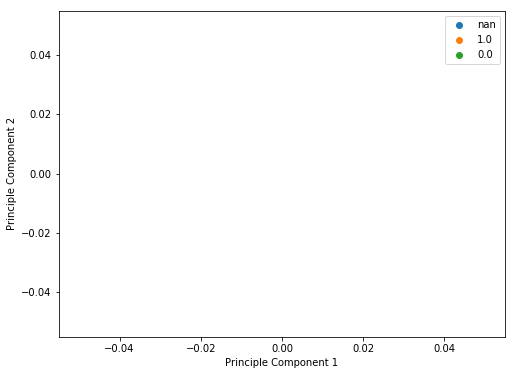

          PC1       PC2
0    0.490656 -1.719521
1    0.010261 -2.846743
2    1.009695 -2.170795
3    0.980512 -1.601263
4    1.033874 -1.123375
5    1.681480 -1.493887
6   -4.136602  2.169902
7   -4.736004  0.655321
8   -4.280671  0.578823
9   -4.398421  0.342824
10  -4.285378  0.680637
11  -4.278662  0.432715
12  -4.002314  1.397830
13  -3.982049  2.313989
14   4.972427 -0.980533
15   4.002844 -1.186695
16   2.830572 -0.497820
17   1.452804 -1.246368
18   0.209545 -1.533975
19   0.035778 -1.853280
20  -0.081379 -1.831635
21   3.564343  1.141910
22  11.190483  5.393990
23  -4.269027 -0.437766
24  -4.282478 -0.079924
25  -4.240515  0.445263
26  -4.350752 -1.055233
27  -4.327903 -1.466684
28  -3.936313  0.319770
29   7.072236 -0.324569
..        ...       ...
47   1.715786 -1.451831
48   1.302904 -2.108765
49   1.463284 -2.635744
50  -3.882914  1.316925
51  -3.122696  3.046883
52  -3.148666  3.095167
53  -2.463010  5.912214
54  -2.400636  5.618258
55  -2.732589  7.690021
56   2.562287 -0

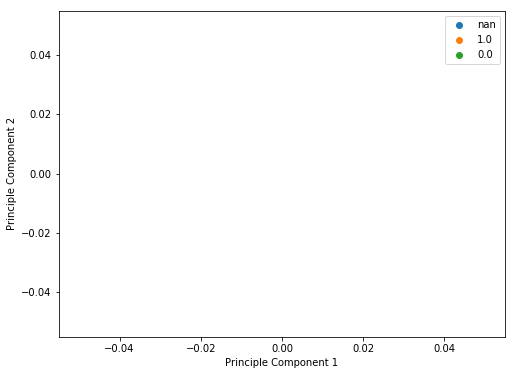

          PC1        PC2
0   -1.472971   1.014735
1   -0.662522   0.741580
2    0.105395   1.607605
3    0.497089   1.515396
4    0.648593  -0.727799
5    0.175160  -1.417538
6   -3.916854   1.658384
7   -3.465001  -1.819683
8   -3.100677  -2.122271
9   -3.317602  -2.689283
10  -3.969419  -2.680443
11  -3.871146  -2.289645
12  -3.988869  -1.569981
13  -4.259794  -0.085806
14   3.049223   5.222969
15   3.290750   4.987312
16   1.123803  -1.620124
17   1.358155  -2.050587
18   1.627458  -2.353403
19   1.161342  -2.684052
20   2.015338  -2.567487
21   3.202799   2.971712
22  -4.434128   1.927973
23  -4.982991   1.269399
24  -4.150239   1.434574
25  -4.338896   1.299413
26  -4.739790   2.786992
27  -4.536412   1.068107
28  -4.159339  -0.107417
29   3.497459  -2.786249
..        ...        ...
65  -3.210993  -0.255322
66  -3.405649  -0.482137
67  -3.735742   0.265722
68  -3.764506  -0.609308
69   7.263163   3.317820
70   7.621629   2.639358
71   4.017534  -2.242684
72   4.464126  -3.001953


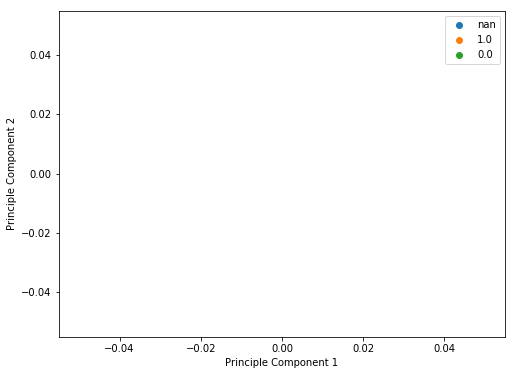

         PC1       PC2
0   8.389921 -2.249208
1   8.160692  1.034632
2   4.359902  0.702787
3   4.846319 -0.833017
4   5.508455  0.326335
5   4.054870 -3.351025
6   3.090177 -1.327917
7   2.826351  8.125322
8  -3.142693 -4.589757
9  -4.309242  0.015645
10 -5.001050  1.322666
11 -4.979499  0.394072
12 -4.063531  0.665531
13 -4.781626  0.059262
14 -5.218181 -0.379148
15 -4.921782  0.363532
16 -4.819085 -0.279713
       SubjID  Visit TaskAbb  Clip  Tremor  Bradykinesia  Dyskinesia  Overall  \
11257  1030.0      6    FtnL     0     1.0           1.0         0.0      1.0   
11258  1030.0      6    FtnL     1     1.0           1.0         0.0      1.0   
11259  1030.0      6    FtnL     2     1.0           1.0         0.0      1.0   
11260  1030.0      6    FtnL     3     1.0           1.0         0.0      1.0   
11261  1030.0      6    FtnL     4     1.0           1.0         0.0      1.0   
11262  1030.0      6    FtnL     5     1.0           1.0         0.0      1.0   
11263  1030.0      

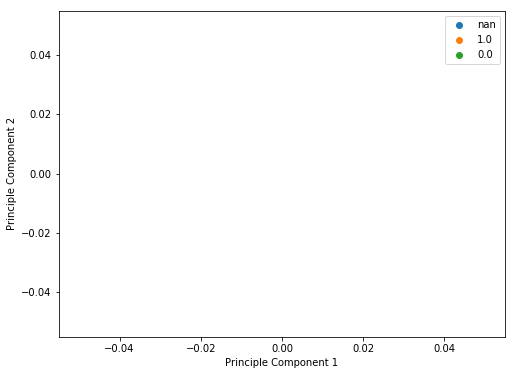

          PC1       PC2
0    1.527719 -1.257808
1    3.443029 -1.504784
2    3.785010  0.333095
3    2.254870  1.410441
4    1.817616 -2.245778
5    0.718986 -1.442648
6    0.912754 -0.417589
7    1.914276 -1.376867
8   -3.727789 -2.177951
9   -4.150153 -0.644541
10  -4.052680 -1.273636
11  -4.340143  0.434424
12  -4.523448  0.351508
13  -4.592360 -0.225285
14   6.738938  0.551930
15   4.793925  0.086396
16   4.682436 -1.069514
17   3.818929 -1.850863
18   4.248028 -0.475863
19   4.300989 -0.364536
20  -4.081503  3.478265
21  -4.892371  4.529750
22  -5.908848  7.218061
23  -5.601708  6.586660
24  -4.895605  5.546507
25  -5.012737  5.768636
26  10.136914  3.153451
27   7.546137  0.787512
28   8.527042 -0.462243
29   7.998488  0.437917
..        ...       ...
61  -3.820363 -3.496141
62  -5.228739  1.974404
63  -5.490333  2.528514
64  -4.156249 -1.842402
65   4.529659 -0.307173
66   3.086742 -0.697469
67   2.075187 -0.408155
68   3.167222  1.329199
69   3.061221  1.362105
70  -3.122339 -2

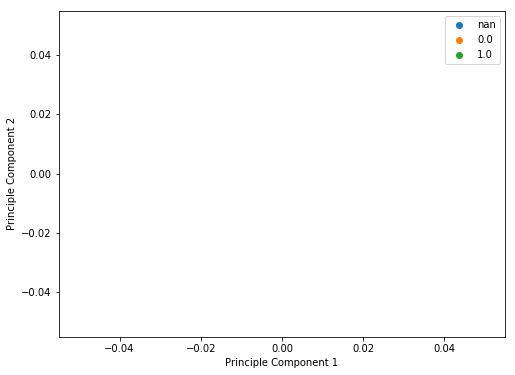

          PC1        PC2
0    4.292401  -3.041279
1    4.117218  -3.248633
2    2.566415  -2.738461
3    2.557476  -2.603536
4    1.508016  -2.596837
5    1.356903  -3.033472
6    3.814983  -3.589190
7   -3.389823   1.708736
8   -3.913707   1.867912
9   -4.437175   1.717572
10  -4.354494   1.074846
11  -4.036878   1.672273
12  -3.687128   1.782663
13   2.187473  -2.284482
14   0.870836  -2.338500
15   0.492814  -1.974576
16   0.857800  -1.870555
17   1.107194  -1.856533
18   1.769550  -1.447802
19   1.601549  -0.533450
20  19.141554  10.442161
21  20.641387  11.283423
22  -3.750369   1.669631
23  -4.016950   1.806061
24  -4.757971   1.257134
25  -2.185325   2.415866
26  -1.745285   2.980331
27  -2.406310   2.373904
28   4.798332  -1.114262
29   5.282409  -1.669279
..        ...        ...
54  -4.421996   1.298523
55   2.894117  -3.077863
56   1.799119  -2.501720
57   2.242604  -1.607797
58   2.480195  -2.026506
59   0.697120  -1.754589
60   1.054340  -2.080030
61   0.259327  -1.837104


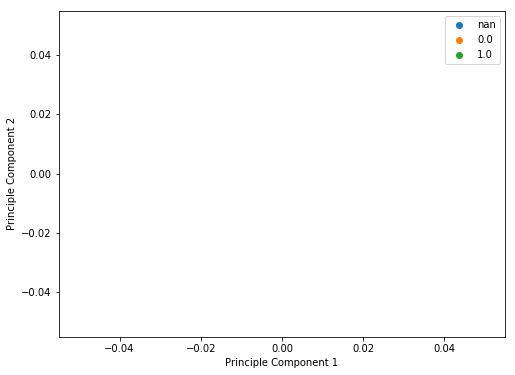

          PC1        PC2
0   -0.418167  -2.278508
1   -0.296727   0.588590
2   -0.810577   1.611234
3   -3.639746  -0.441121
4   -3.524283  -0.921328
5   -3.519472  -1.342081
6   -4.261229  -0.850223
7    1.597932   1.465368
8    4.058346   2.651402
9    4.514935   2.399294
10   3.176534   0.070953
11   4.005281   3.387997
12  -3.957074   1.624500
13  -3.607594   0.103425
14  -4.093576   0.182499
15  -4.304172  -0.246185
16  -3.930214  -1.453835
17   4.211344   0.389530
18   4.318576  -0.217953
19   3.392784  -1.051212
20   5.140626   0.565965
21   5.736394  -0.735250
22   6.277428  -1.443143
23  -3.593505   4.897193
24  -3.739105   1.357077
25  -3.752425  -0.279412
26  -3.335602  -0.211096
27  -3.218536   1.039890
28  -4.095194  16.169827
29   4.635167  -1.694726
..        ...        ...
42   3.850893  -2.519021
43   3.812677  -3.017111
44   3.310898  -3.095695
45   3.715845  -2.453094
46  -3.535166  -0.063223
47  -3.463897   2.159417
48  -3.510010   0.353898
49  -3.273672   0.055584


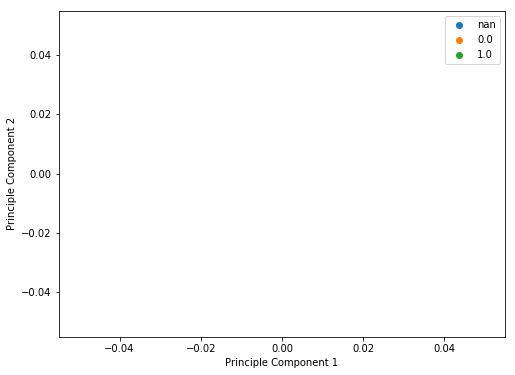

          PC1        PC2
0    0.491308   0.281115
1    0.394090   0.264487
2   -0.488447  -0.900612
3   -0.340884  -0.441270
4   -0.351835  -1.096465
5   -2.639342   3.970942
6   -3.145867   1.411999
7   -2.826825   2.343624
8   -3.345030   1.433685
9   -3.273524   1.755892
10  -3.454617   1.815605
11   0.062813  -2.041090
12   0.061379  -1.633069
13   0.148585  -1.283195
14  -3.330110   1.398248
15  -3.298426   1.636981
16  -3.230194   0.774585
17  -3.089359   2.092637
18  -3.271502   2.018565
19   2.412355  -3.596576
20   2.658500  -3.911403
21   1.939143  -3.712744
22   2.108358  -4.012446
23   2.065026  -4.606415
24   6.711798   3.613766
25  -2.729965   2.676666
26  -3.371604   0.773360
27  -2.940880   2.705577
28  -2.610073   3.074749
29  -2.686014   2.207326
..        ...        ...
43   2.457846  -3.676778
44   2.357472  -3.163786
45   2.889391  -5.107454
46  15.065385   5.705562
47  -2.807082   0.868681
48  -2.723755   1.676021
49  -3.099564   2.116344
50  -3.044088   2.950782


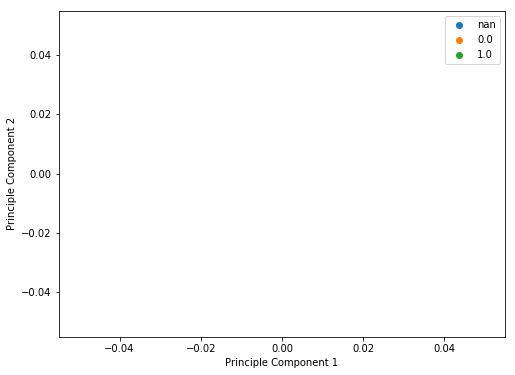

          PC1       PC2
0   -4.786522  2.218622
1   -4.280208 -1.171323
2   -3.970417 -1.585216
3   -4.036673 -1.689376
4   -3.553001 -2.052626
5   -3.933606 -0.777194
6    1.711676  0.337576
7    0.707277  1.568120
8    0.944956  2.398165
9    1.801775  0.988175
10   2.285685  0.716459
11   2.011338  0.971491
12   1.762648 -0.190013
13   1.331374 -0.789369
14  -4.799373  1.381664
15  -4.100372 -0.654476
16  -4.076737 -1.194349
17  -3.895508 -1.288002
18  -4.497180 -1.258699
19  -4.473847 -2.262880
20  -4.309964 -1.690700
21  -4.722736  1.893181
22  -4.352634 -0.414686
23  -4.148223 -1.165955
24  -4.184436 -1.144246
25  -4.281479 -1.407554
26  -4.162356 -0.278463
27   5.043083  1.943072
28   4.789863  1.273839
29   3.868210  1.252966
..        ...       ...
58   6.374071 -1.339793
59  -4.424157  5.042744
60  -4.087851  0.631962
61  -4.261898 -0.309674
62  -3.887672 -0.515698
63  -3.676648 -1.010151
64  -3.888188 -1.118181
65  -3.993396  0.393024
66  -3.641310 -1.899303
67   8.496269  7

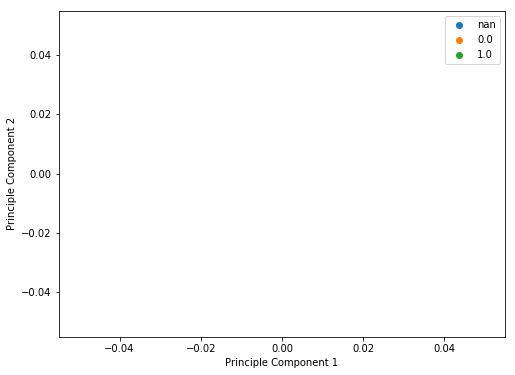

         PC1       PC2
0  -4.300390  2.288253
1  -4.655560  0.955432
2  -4.847002  1.831516
3  -5.021925  2.366009
4  -5.027928  0.933587
5  -4.881655  1.471324
6  -5.134921  1.360925
7   3.113141 -0.602964
8   4.233895 -0.126397
9   4.316751 -0.261450
10  3.778333 -1.185987
11  2.604445 -1.359016
12  2.157945 -1.074829
13  1.868831 -1.790850
14 -3.295846  2.016745
15 -4.233340  0.591153
16 -4.687977  0.536024
17 -4.541627  0.025130
18 -4.300619 -0.004364
19 -4.216885 -0.080531
20  4.605106  0.744514
21  4.569876 -1.092253
22  3.436640 -0.880541
23  4.398791  0.099433
24  4.245050  0.462141
25  2.743546 -0.496223
26  4.332888 -0.642712
27 -3.986511  0.192933
28 -4.282281  0.648191
29 -4.370849  1.406042
..       ...       ...
64  3.003127 -0.865518
65  2.029082 -1.277333
66 -1.546925  1.763459
67 -4.388873  1.363115
68 -4.379314  0.365691
69 -4.132189  0.467779
70 -4.623707 -0.070613
71 -4.912570 -0.557217
72 -3.052199  0.883717
73  4.199737 -1.366596
74  3.687231 -2.333696
75  2.98295

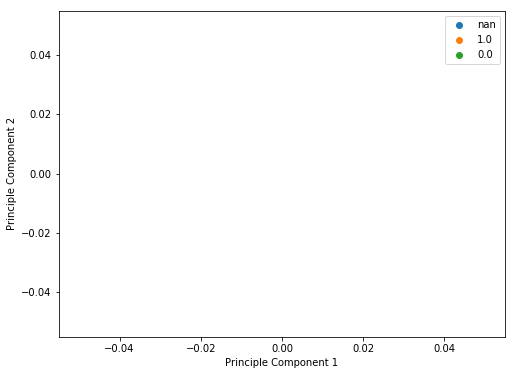

          PC1       PC2
0    0.037813 -6.056449
1   -0.336063 -6.049818
2   -0.430229 -5.743916
3    0.279862 -5.021786
4   -0.010146 -6.648490
5    0.052179 -4.620638
6   -0.788770 -4.528503
7   -1.191995 -3.474450
8   -1.836234 -2.999649
9    0.274567 -2.290297
10   0.692674 -2.898089
11  -0.979246  0.596386
12  -0.536103  1.560036
13  -0.696009  0.794614
14  -0.725829 -1.510883
15  -0.370398  0.199854
16  -0.104664  0.841435
17  -0.766099  0.446198
18   0.154472  1.054790
19   0.430970  0.538212
20  -3.880843  1.399196
21  -3.840082  1.222620
22  -4.280394  0.504659
23  -4.389151  0.891346
24  -4.113137  1.765830
25  -3.426140  3.249907
26  -3.109577  4.067726
27  -3.512051  4.312013
28  -3.613368  3.831162
29  -4.369390  0.708026
..        ...       ...
78  -1.218162 -0.827554
79  -1.232151  0.075339
80  -1.839443 -0.442038
81  -1.884810  0.019824
82  -1.848412  0.658296
83   0.147526 -3.196240
84   0.281763 -2.600286
85  -0.359545 -3.157868
86  -1.218421 -2.744381
87  -1.238707 -2

[216 rows x 11 columns]


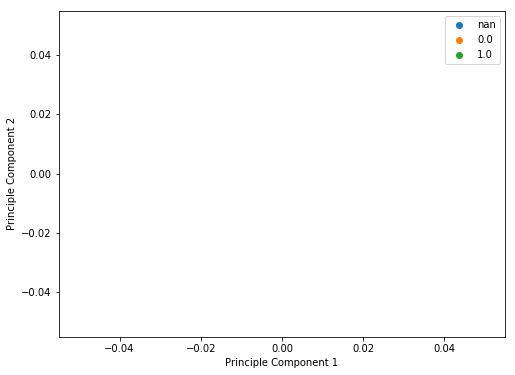

         PC1       PC2
0   1.906099 -1.825658
1   1.703334 -2.373170
2   1.593465 -3.552199
3   1.259322 -2.932889
4   1.644906  1.440120
5   2.065456  0.824307
6   3.822698 -1.266113
7   4.284311 -1.870144
8   3.403686 -1.479205
9   1.918174 -2.091250
10  2.571602 -2.029644
11  5.653756 -3.253184
12  4.940266 -3.391750
13 -0.016490 -0.214622
14  0.124202  0.327965
15 -0.859893  0.864535
16  1.327611 -0.642397
17  1.865428  0.210657
18  0.771267  1.341707
19 -0.050238  0.690304
20  0.240289  0.845858
21  0.594008  0.685213
22 -4.732793  0.707722
23 -4.457292  5.087454
24 -4.416785  3.946942
25 -4.937215  0.593329
26 -4.975192  2.404876
27 -5.005498  2.283690
28 -5.146739  0.494777
29  0.721175 -1.510572
..       ...       ...
58  2.109470  0.616226
59  1.188311 -1.563493
60  0.182158 -1.025909
61 -0.286072 -2.008535
62  0.257810 -0.659039
63 -2.274566 -1.541531
64 -2.805198  0.043767
65 -2.939137  0.355529
66 -3.021450 -0.058715
67  0.862200  0.213676
68  5.311261 -3.640391
69  4.81248

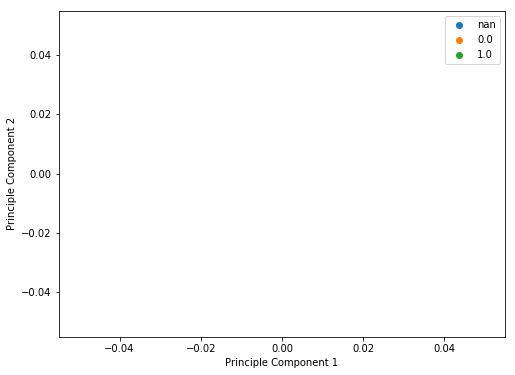

           PC1       PC2
0    22.066845  9.778757
1    21.677759  8.414999
2     4.848407 -0.804295
3     7.066870  0.064114
4     6.005207  1.608595
5     4.702249  2.899512
6     8.932309  2.516820
7    10.433392  2.665590
8    13.404285  1.809516
9    11.590001  1.469078
10    8.898693  1.523729
11   -2.896375  8.455283
12   -3.882458  1.652125
13   -3.961111  0.814510
14   -3.796799  0.805077
15   -3.419108  0.221327
16   -3.147596  1.536494
17   -2.879700  1.487940
18   -2.409327  1.612357
19   -2.094691  0.658380
20   -1.805996  0.531950
21   -1.279617 -0.212162
22    2.256907 -2.938370
23    1.877205 -2.529549
24    1.310489 -3.044612
25    1.202559 -2.706627
26    0.437491 -1.856022
27    0.070998 -2.127608
28    0.173254 -2.598414
29    0.719339 -2.445239
..         ...       ...
125  -4.003591  0.133274
126  -3.887338 -0.138501
127  -3.445296  1.381230
128  -3.809940  0.711415
129  -3.856148  0.797342
130  -3.409651  1.168719
131  -3.371363  0.753253
132  -3.498957  2.163861


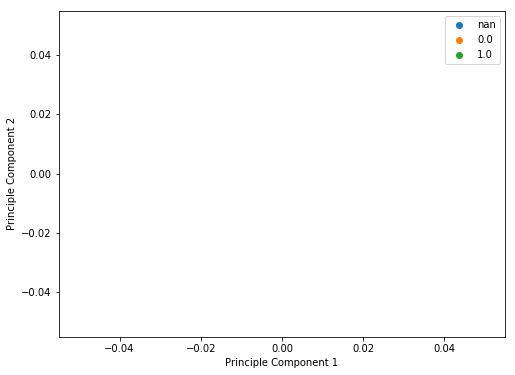

         PC1        PC2
0   1.612111  -1.147152
1   0.395683  -0.488892
2   0.036166   0.174735
3   0.412641  -0.883157
4   1.433117   0.494713
5   1.929916   0.931755
6   6.771078   9.855392
7  -4.688378  -0.522385
8  -4.579956  -1.727125
9  -4.929617  -1.224296
10 -4.870479  -0.077490
11 -4.811299   1.141087
12  3.056186  -0.933509
13  1.354932  -1.858916
14  1.154502  -2.179442
15  0.997106  -1.535319
16  1.102998  -1.035175
17  1.623474  -0.525523
18  1.773560  -0.789411
19 -4.123301  -1.353254
20 -4.501048  -0.885012
21 -4.620006  -0.610672
22 -4.482237   0.672914
23 -4.709194   0.592648
24  1.567788  -2.548421
25  0.904331  -1.954012
26  1.300013  -1.117817
27  1.469554  -2.291559
28  0.344934  -1.185996
29  0.596989  -0.877839
..       ...        ...
57 -4.557711  -1.387266
58 -4.599267  -1.992656
59 -4.726346  -1.542500
60 -4.597790  -1.448347
61  6.996580  -0.828545
62  5.533225  -1.966102
63  5.346479  -1.249655
64  6.112614  -1.169015
65  6.765226  -0.302807
66  5.704076   0

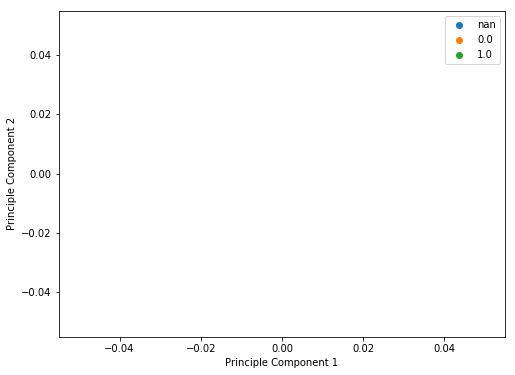

In [252]:
### TASKS
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']
# tasks = ['RamL', 'RamR']
tasks = ['FtnL', 'FtnR']
# tasks = ['Sitng', 'Stndg', 'Drwg']
# tasks = ['Wlkg', 'WlkgCnt']
# tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']

### NEWLAB, GROUPS
# newLab, groups = ['Excld', 'Ram', 'Ftn', 'Rest', 'Wlkg', 'FinMot'], [['SitStand'], ['RamL', 'RamR'], ['FtnL', 'FtnR'], ['Sitng', 'Stndg', 'Drwg'], ['Wlkg', 'WlkgCnt'], ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']]
newLab, groups = ['NoSymp', 'Symp'], [[float(0)], [float(1), float(2), float(3), float(4)]]
# newLab, groups = [], []

bestFeatIdx = []

## RERUN MODEL WITH ONLY N MOST IMPORTANT FEATURES
# model, FeatImp = TrainTestModel(label_type, tasks, newLab, groups, bestFeatIdx)
# AvgFeatImp = np.mean(FeatImp, axis = 0)
# bestFeatIdx = list(AvgFeatImp.argsort()[-10:][::-1])

DataClusters, km = TrainTestCluster(tasks, newLab, groups, bestFeatIdx)

True